In [1]:
from pathlib import Path
import copy
from tqdm import tqdm
from itertools import product

import torch
import pyscf
import numpy as np
import opt_einsum as oe
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc

from cadft.utils import Grid
from cadft import CC_DFT_DATA, Mol
from cadft.utils import gen_basis


rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)
rc("font", family="serif")

rcParams["text.latex.preamble"] = thesis_latex

fontsize = 10.045
sca_size = 2
plt.rc("font", size=fontsize)  # controls default text size
plt.rc("axes", titlesize=fontsize)  # fontsize of the title
plt.rc("axes", labelsize=fontsize - 1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=fontsize - 2)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=fontsize - 2)  # fontsize of the y tick labels
plt.rc("legend", fontsize=fontsize)  # fontsize of the legend

plt.rcParams["figure.figsize"] = np.array([0.95, 0.5]) * 520 / 72

rcParams["axes.linewidth"] = 1.5
rcParams["lines.linewidth"] = 1.5
rcParams["xtick.major.width"] = 3
rcParams["xtick.minor.size"] = 5
rcParams["xtick.major.size"] = 5
rcParams["ytick.minor.size"] = 5
rcParams["ytick.major.size"] = 5
rcParams["xtick.minor.width"] = 1.5
rcParams["xtick.major.width"] = 1.5
rcParams["ytick.minor.width"] = 1.5
rcParams["ytick.major.width"] = 1.5

mol_list = ["methane", "ethane"]
# mol_list = ["ethane", "acetylene"]

distance_list = [0]

ang_to_au = 1 / 0.52917721067

MAIN_PATH: /home/dhem/workspace/2024.1
DATA_PATH: /home/dhem/workspace/2024.1/data/grids_mrks
DATA_SAVE_PATH: /home/dhem/workspace/2024.1/data/grids_mrks/saved_data
DATA_CC_PATH: /home/dhem/workspace/2024.1/data/test


(9, 9)
1697


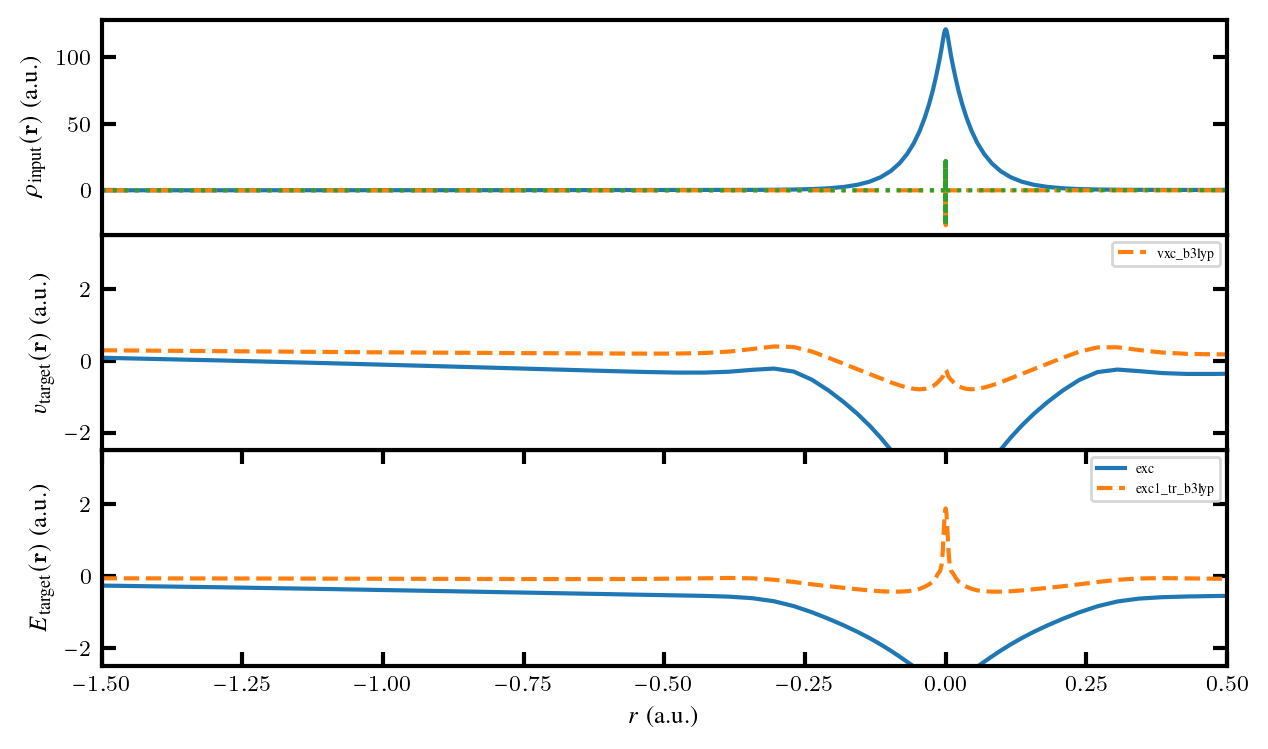

(16, 16)
3402


<Figure size 686.111x361.111 with 0 Axes>

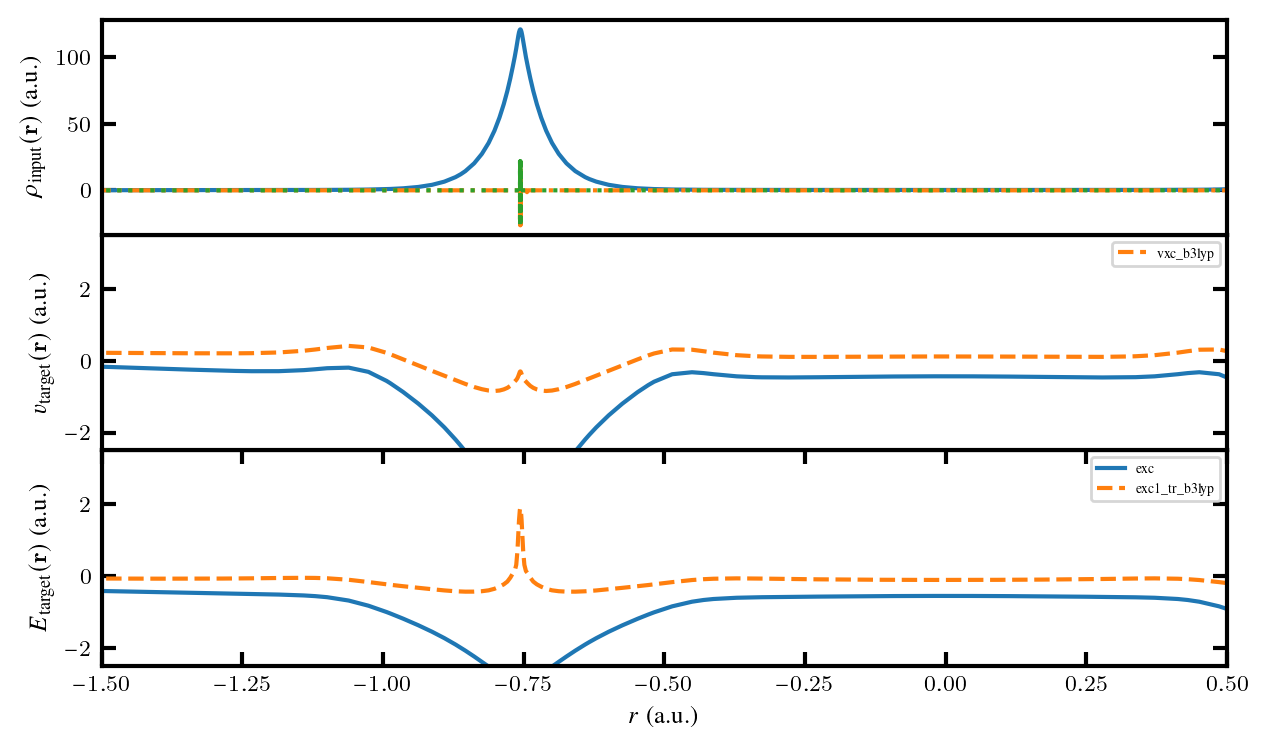

<Figure size 686.111x361.111 with 0 Axes>

In [14]:
for mol, distance in product(mol_list, distance_list):
    molecular = copy.deepcopy(Mol[mol])
    molecular[0][1] += distance

    dft2cc = CC_DFT_DATA(
        molecular,
        name="test",
        basis="STO-3G",
        if_basis_str=True,
    )

    mf = pyscf.scf.RHF(dft2cc.mol)
    mf.kernel()
    print(mf.make_rdm1().shape)

    mycc = pyscf.cc.CCSD(mf)
    mycc.kernel()
    dm1_cc = mycc.make_rdm1(ao_repr=True)
    dm2_cc = mycc.make_rdm2(ao_repr=True)
    e_cc = mycc.e_tot

    mdft = pyscf.scf.RKS(dft2cc.mol)
    mdft.xc = "b3lyp"
    mdft.kernel()
    e_dft = mdft.e_tot
    dm1_dft = mdft.make_rdm1(ao_repr=True)

    grids = Grid(dft2cc.mol)
    coords = grids.coords
    weights = grids.weights
    ao_2 = pyscf.dft.numint.eval_ao(dft2cc.mol, coords, deriv=2)
    ao_0 = ao_2[0, :, :]
    ao_value = ao_2[:4, :, :]
    ao_2_diag = ao_2[4, :, :] + ao_2[7, :, :] + ao_2[9, :, :]

    rho_dft = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_dft, xctype="GGA")
    rho_cc = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_cc, xctype="GGA")

    rho_dft_grids = grids.vector_to_matrix(rho_dft[0])
    rho_cc_grids = grids.vector_to_matrix(rho_cc[0])

    data = np.load(
        f"../data/grids_mrks_CVTZ_1/data/data_{mol}_cc-pCVTZ_0_1_{distance:.4f}.npz"
    )
    # data = np.load(
    #     "../data/grids_mrks_CVTZ_1/data/data_methane_cc-pCVTZ_0_1_-0.5000_bk.npz"
    # )

    exc = data["exc"]
    exc1_tr_b3lyp = data["exc1_tr_b3lyp"]
    vxc = data["vxc"]
    vxc_b3lyp = data["vxc_b3lyp"]
    rho_inv = data["rho_inv"]
    rho_inv_4 = data["rho_inv_4"]

    index_ = np.where((np.abs(coords[:, 1]) < 1e-4) & (np.abs(coords[:, 2]) < 1e-4))
    sort_ = np.argsort(coords[:, 0][index_])
    x = coords[:, 0][index_][sort_] / ang_to_au
    r_vec = np.linalg.norm(grids.coords[index_][sort_], axis=1)
    r_cut_off = 1 / (1 + np.exp(1 * (r_vec - 10)))
    y11 = (grids.matrix_to_vector(exc))[index_][sort_]
    y12 = (grids.matrix_to_vector(exc1_tr_b3lyp))[index_][sort_]
    y13 = (grids.matrix_to_vector(exc1_tr_b3lyp_all))[index_][sort_]
    y21 = (grids.matrix_to_vector(vxc))[index_][sort_]
    y22 = (grids.matrix_to_vector(vxc_b3lyp))[index_][sort_]
    y31 = (grids.matrix_to_vector(rho_inv_4[0,:,:,:]))[index_][sort_]
    y32 = (grids.matrix_to_vector(rho_inv_4[1,:,:,:]))[index_][sort_]
    y33 = (grids.matrix_to_vector(rho_inv_4[2,:,:,:]))[index_][sort_]
    y34 = (grids.matrix_to_vector(rho_inv_4[3,:,:,:]))[index_][sort_]

    f, axes = plt.subplots(3, 1)
    axes = axes.reshape(3, 1)

    begin_y = 0.1
    end_y = 0.995
    int_y = 0.0
    begin_x = 0.175
    end_x = 0.995
    int_x = 0.0
    end_x += int_x
    end_y += int_y

    shapexy = np.shape(axes)
    inter_x = np.linspace(begin_x, end_x, shapexy[1] + 1)
    inter_y = np.linspace(begin_y, end_y, shapexy[0] + 1)

    delta_x = inter_x[1] - inter_x[0] - int_x
    delta_y = inter_y[1] - inter_y[0] - int_y

    for i in range(shapexy[0]):
        for j in range(shapexy[1]):
            axes[i][j].set_position(
                [
                    inter_x[j],
                    inter_y[i],
                    inter_x[j + 1] - inter_x[j] - int_x,
                    inter_y[i + 1] - inter_y[i] - int_y,
                ]
            )
            axes[i][j].xaxis.set_tick_params(
                direction="in", which="both", bottom=True, top=True
            )
            axes[i][j].yaxis.set_tick_params(
                direction="in", which="both", left=True, right=True
            )

    axes = axes[::-1, :]

    axes[0, 0].plot(x, y31)
    # axes[0, 0].plot(x, y32, "--")
    axes[0, 0].plot(x, y33, "-.")
    axes[0, 0].plot(x, y34, ":")

    axes[1, 0].plot(x, y21)
    axes[1, 0].plot(x, y22, "--", label="vxc_b3lyp")

    axes[2, 0].plot(x, y11, label="exc")
    axes[2, 0].plot(x, y12, "--", label="exc1_tr_b3lyp")

    # axes[0, 0].set_xlim(-10, 10)
    # axes[1, 0].set_xlim(-10, 10)
    # axes[2, 0].set_xlim(-10, 10)

    axes[0, 0].set_xlim(-1.5, 0.5)
    axes[1, 0].set_xlim(-1.5, 0.5)
    axes[2, 0].set_xlim(-1.5, 0.5)

    # axes[0, 0].set_ylim(-10, 160)
    # axes[0, 0].set_yticks([0, 50, 100, 150])
    # axes[1, 0].set_ylim(-1.1, 0.6)
    # axes[1, 0].set_yticks([-1, -0.5, 0, 0.5])
    # axes[2, 0].set_ylim(-1.5, 2.5)
    # axes[2, 0].set_yticks([-1, 0, 1, 2])

    axes[0, 0].set_ylabel(r"$\rho_{\textrm{input}}(\bm{\mathrm{r}})$ (a.u.)")
    axes[1, 0].set_ylabel(r"$v_{\textrm{target}}(\bm{\mathrm{r}})$ (a.u.)")
    axes[2, 0].set_ylabel(r"$E_{\textrm{target}}(\bm{\mathrm{r}})$ (a.u.)")

    axes[0, 0].set_xticks([])
    axes[1, 0].set_xticks([])
    axes[2, 0].set_xlabel(r"$r$ (a.u.)")

    print(len(x))
    # plt.savefig(f"../manu/figures/{mol}_cc-pCVTZ_0_1_{distance:.4f}.pdf")
    axes[1, 0].legend(loc="best", fontsize=fontsize // 2)
    axes[2, 0].legend(loc="best", fontsize=fontsize // 2)
    axes[1, 0].set_ylim(-2.5, 3.5)
    axes[2, 0].set_ylim(-2.5, 3.5)
    # # axes[0].set_xlim(-5, 105)
    # # axes[1].set_xlim(-5, 105)
    plt.show()
    plt.clf()

ValueError: x and y arrays must have a length of at least 3

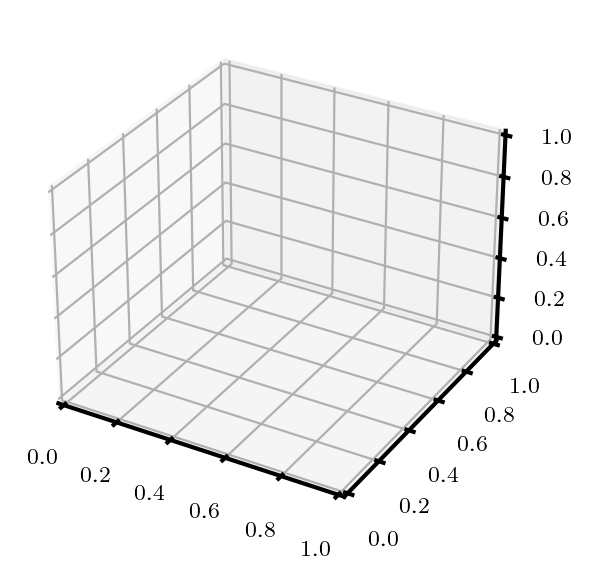

In [5]:
index_ = np.where((np.abs(coords[:, 2]) < 1e-10))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y = coords[:, 1][index_][sort_]
# z11 = (grids.matrix_to_vector(exc))[index_][sort_]
z12 = (grids.matrix_to_vector(exc_real))[index_][sort_]
# z2 = (grids.matrix_to_vector(vxc))[index_][sort_]

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
# ax.plot_trisurf(x, y, z11, label="exc")
ax.plot_trisurf(x, y, z12, label="exc_real")
# ax.plot_trisurf(x, y, z2, label="vxc")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
# ax.set_zlim(-5, 5)
# plt.xlim(1.13, 1.155)

# plt.legend(loc='upper right')
print(len(x))

In [13]:
import torch

torch.cuda.mem_get_info()[0] // 8 // 140**4

1

In [12]:
for hash_char in ["0", "1"]:
    print("1_1".startswith(f"{hash_char}_"))

False
True


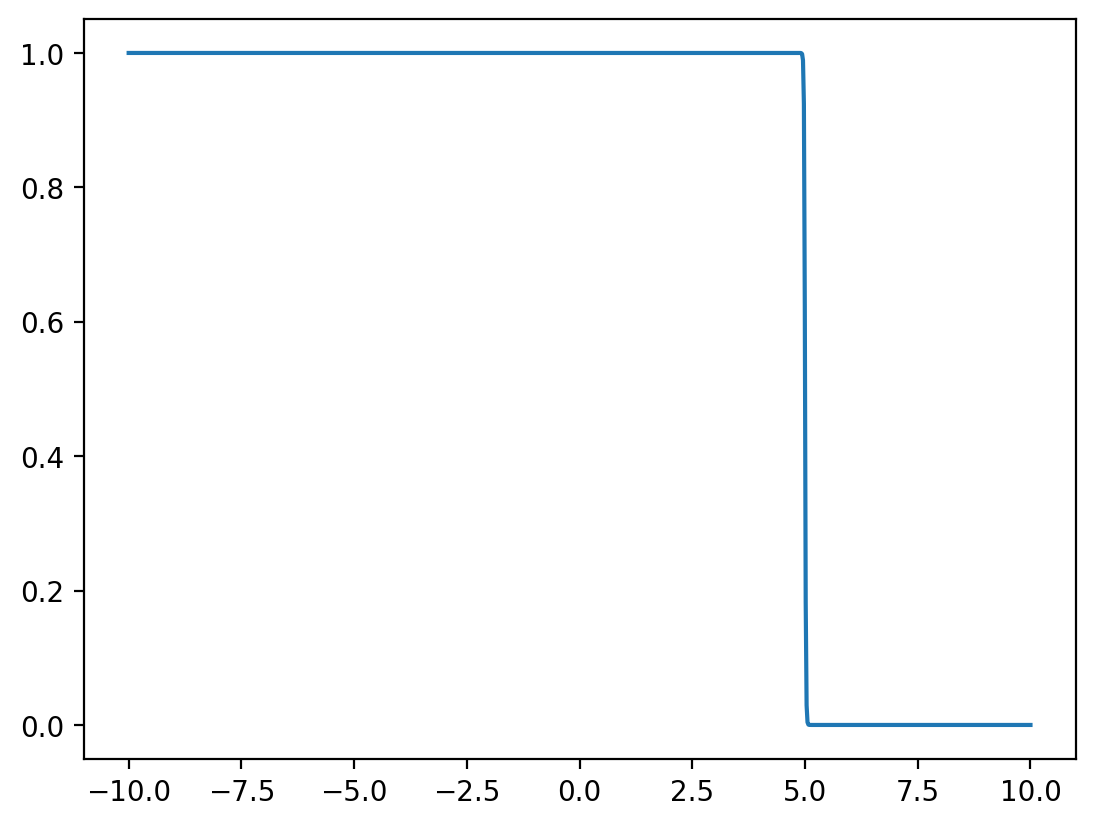

In [11]:
x = np.linspace(-10, 10, 1000)
# plt.plot(x, 1 / (1 + np.exp(-100 * (x-1))))
plt.plot(x, 1/ (1 + np.exp(100 * (x-5))))